In [1]:
import pandas as pd
import numpy as np

In [2]:
PHASES = ['train', 'val', 'test']

In [3]:
def _summarize(row):
    poss = np.array(row[1:])
    score_range = np.arange(1, 11)
    score = sum(poss * score_range)
    std = sum(poss * ((score_range - score) ** 2)) ** 0.5
    return pd.Series([row[0], score, std])

def summarize(df: pd.DataFrame):
    res = df.apply(_summarize, axis=1)
    res = res.astype({0: int})
    res.columns = ['id','mean','std']
    return res

In [4]:
data = {phase:pd.read_csv(f'{phase}_labels.csv', header=None) for phase in PHASES}
sum_data = {k:summarize(v) for k, v in data.items()}

In [5]:
for s in sum_data.values():
    print(s.head())

       id      mean       std
0  953417  6.112903  1.123141
1  953777  6.593750  1.491840
2  953756  5.796875  1.295180
3  954195  5.040984  1.176251
4  953903  5.943548  1.321671
       id      mean       std
0  954222  6.579365  1.481918
1  954141  5.709677  1.281218
2  954014  4.966387  1.321654
3  954092  6.484615  1.376923
4  954022  5.451613  1.303561
       id      mean       std
0  953844  5.914062  1.089921
1  953283  6.755556  1.357921
2  954116  5.541985  1.393877
3  953780  5.041667  1.186001
4  953582  5.943548  1.345856


In [6]:
def statistic(named_data: dict[str, pd.DataFrame], column: str, *, start = 2, stop = 10, step=0.5):
    dd = {'score': [''], **{m: [0] for m in named_data}}
    score_range = np.linspace(start, stop, int((stop - start) / step) + 1)
    for i in range(1, len(score_range)):
        dd['score'].append(f'{score_range[i-1]:.2f}-{score_range[i]:.2f}')
        for col in dd:
            if col == 'score': continue
            dd[col].append(len(named_data[col][named_data[col][column] <= score_range[i]]) - sum(dd[col]))
    return pd.DataFrame(dd).iloc[1:]

In [7]:
stat = statistic(sum_data, column='mean', start=1, stop=9)
stat

,score,train,val,test
1,1.00-1.50,0,0,0
2,1.50-2.00,5,0,1
3,2.00-2.50,96,5,4
4,2.50-3.00,396,21,18
5,3.00-3.50,1443,79,74
6,3.50-4.00,5368,279,298
7,4.00-4.50,17713,956,975
8,4.50-5.00,42201,2316,2406
9,5.00-5.50,62482,3475,3547
10,5.50-6.00,55541,3009,3105


In [8]:
def statistic_detail(data: pd.DataFrame, split_indexes: list = [7, 11]):
    split_indexes.insert(0, 0)
    split_indexes.append(len(data))
    for col in data.columns[1:]:
        print(f'============ Column `{col}` ============')
        for p, q in zip(split_indexes, split_indexes[1:]):
            print(f"Range {data['score'].iloc[p][:4]} -> {(data['score'].iloc[q-1][-4:])}: {sum(data[col][p:q])}")

In [9]:
statistic_detail(stat) # Train: 90%, Val = Test = 5%

============ Column `train` ============
Range 1.00 -> 4.50: 25021
Range 4.50 -> 6.50: 190914
Range 6.50 -> 9.00: 14046
============ Column `val` ============
Range 1.00 -> 4.50: 1340
Range 4.50 -> 6.50: 10537
Range 6.50 -> 9.00: 814
============ Column `test` ============
Range 1.00 -> 4.50: 1370
Range 4.50 -> 6.50: 10714
Range 6.50 -> 9.00: 734


# Grouping

In [10]:
split_scores = [4.5, 6.5]

In [11]:
def grouping(data: pd.DataFrame, splits: list = [4.5, 6.5], column: str = 'mean'):
    ret = []
    ret.append(data[data[column] <= splits[0]])
    data = data.drop(ret[-1].index)
    for q in splits[1:]:
        ret.append(data[data[column] <= q])
        data = data.drop(ret[-1].index)
    ret.append(data[data[column] > splits[-1]])
    return ret

In [12]:
groups = {k:grouping(v) for k,v in sum_data.items()}

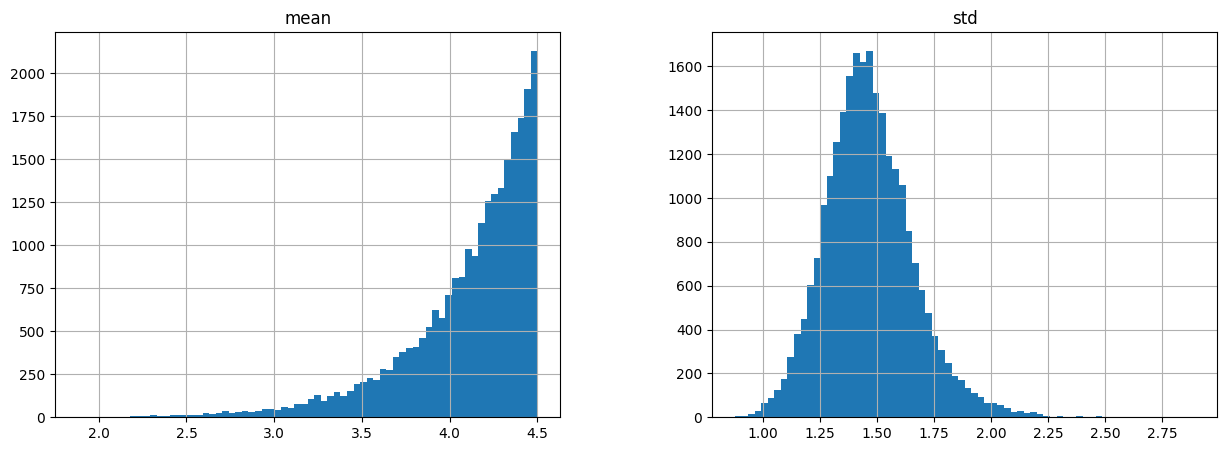

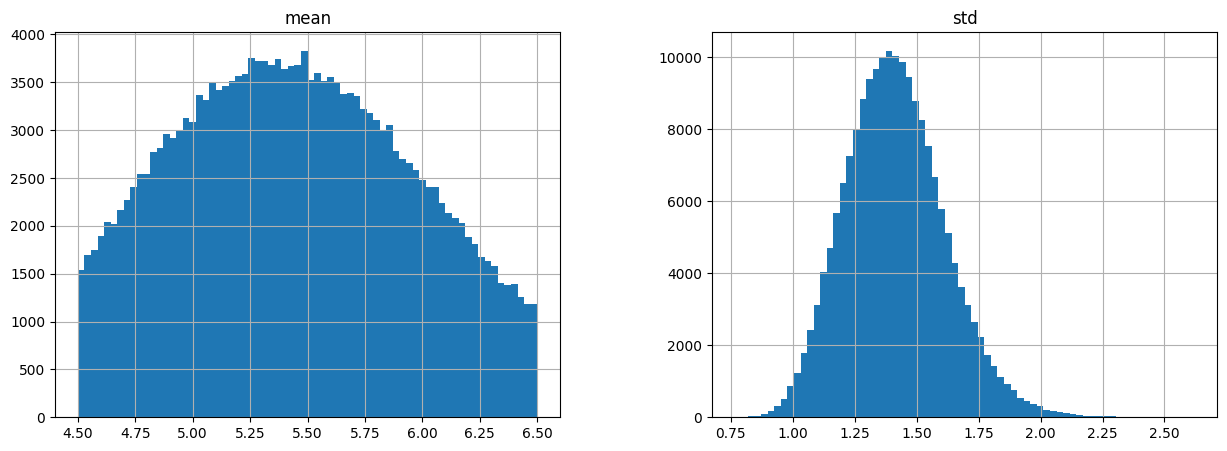

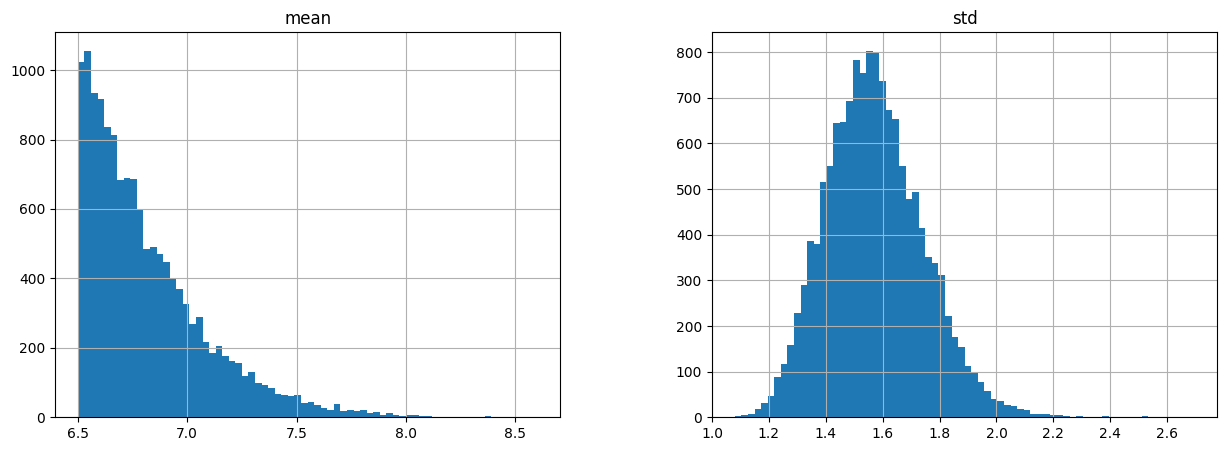

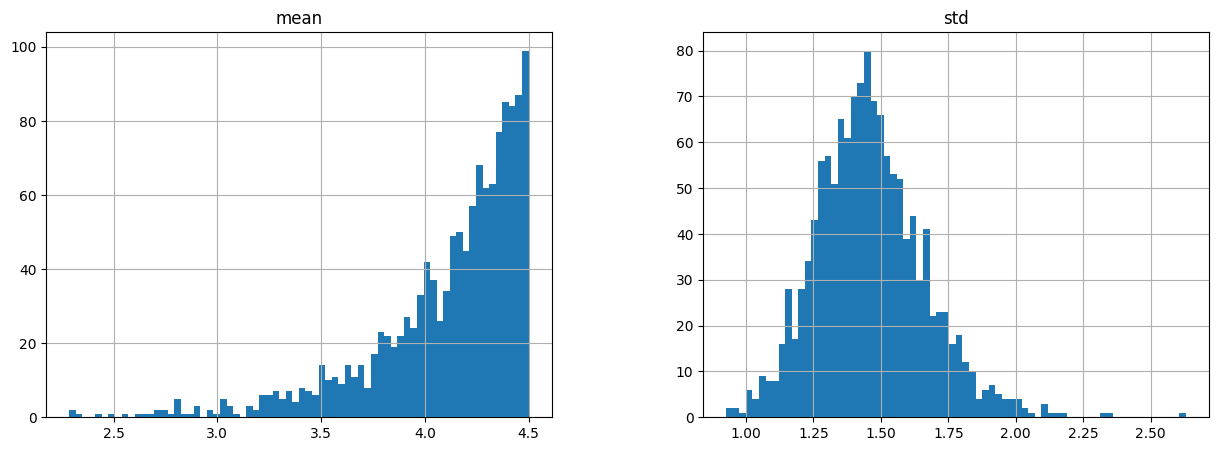

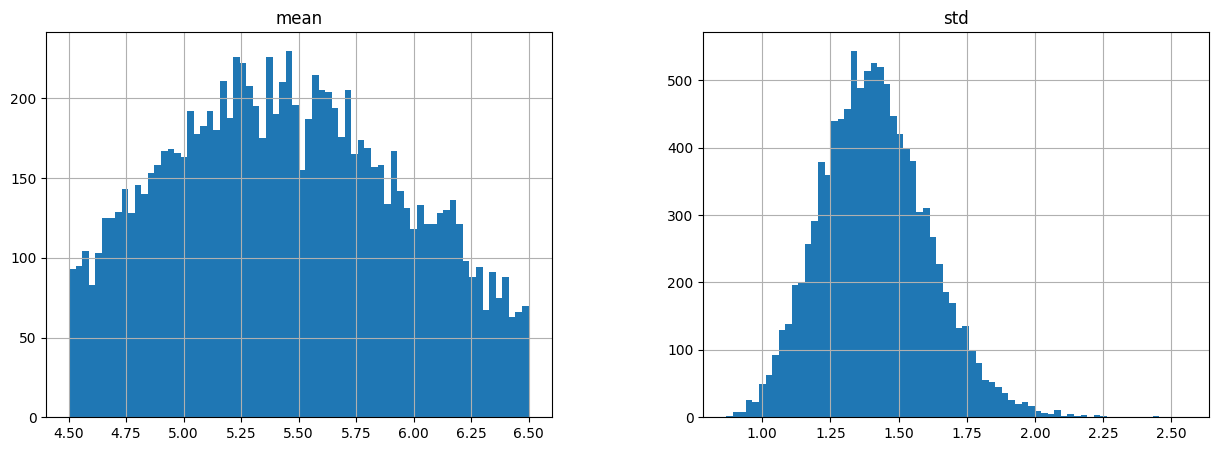

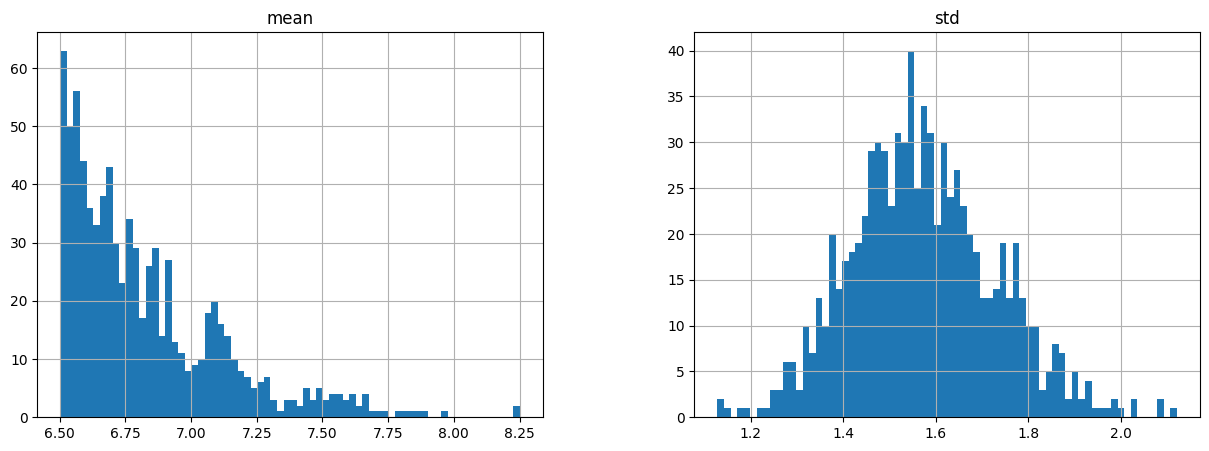

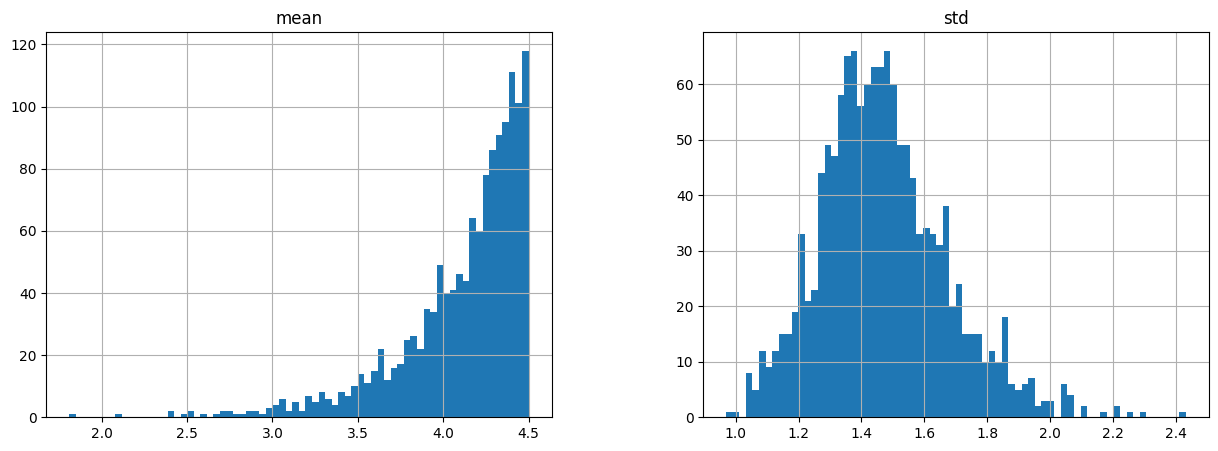

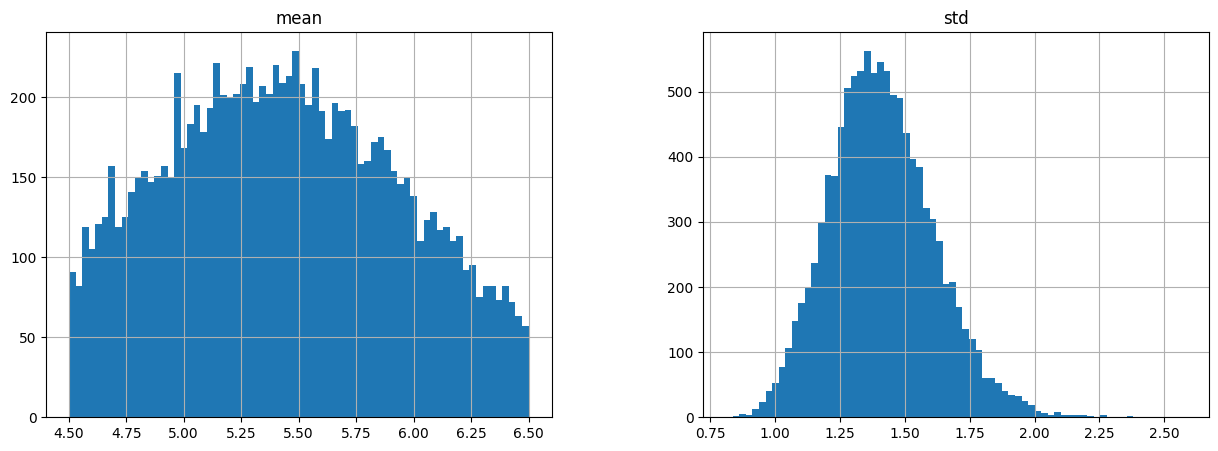

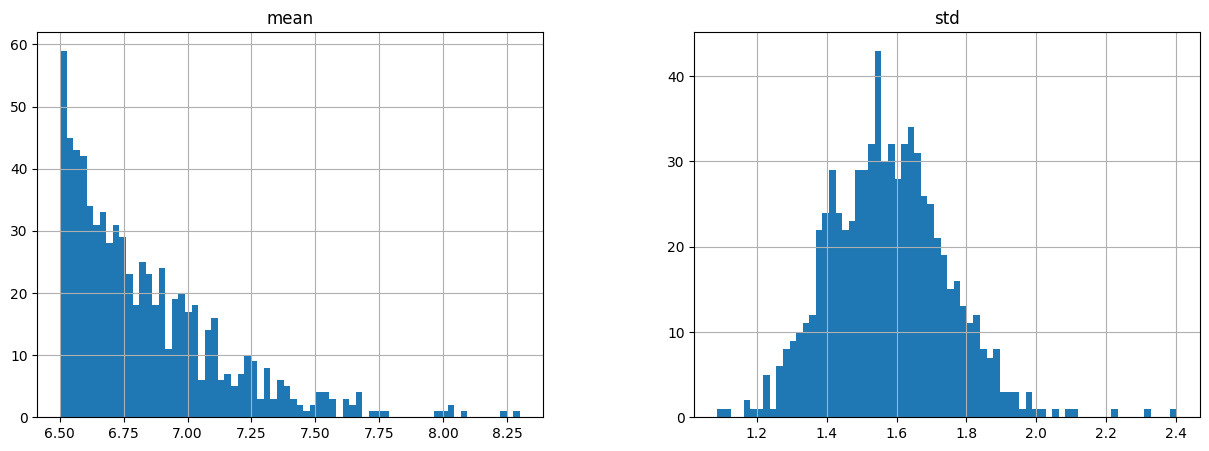

In [13]:
for phase, gr in groups.items():
    for g in gr:
        g.hist(['mean', 'std'], bins=70, figsize=(15, 5))

# To Files

In [15]:
for phase, grs in groups.items():
    print('Phase', phase)
    for ind, gs in enumerate(grs):
        dphase = data[phase]
        g = dphase[dphase[0].isin(gs['id'])]
        print('Group', ind, len(g))
        g.to_csv(f'./data_split/{phase}_group_{ind}.csv', index=None, header=None)

Phase train
Group 0 25021
Group 1 190914
Group 2 14046
Phase val
Group 0 1340
Group 1 10537
Group 2 814
Phase test
Group 0 1370
Group 1 10714
Group 2 734
